# BERTopic topic modeling


Import 

In [ ]:
!pip install octis
!pip install bertopic
!pip install keybert
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import os
import re

import pickle
import nltk 
import gensim
import sklearn
import gensim.corpora as corpora
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timezone
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.cluster import KMeans
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from keybert import KeyBERT
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import TextGeneration

wordnet_lemmatizer = WordNetLemmatizer()
representation_model = KeyBERTInspired()


os.environ["TOKENIZERS_PARALLELISM"] = "false"
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from octis.evaluation_metrics.diversity_metrics import TopicDiversity


# dovrebbero essere quelli giusti

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from octis.models.LDA import LDA


c:\Users\pluez\anaconda3\envs\Py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\pluez\anaconda3\envs\Py38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\pluez\anaconda3\envs\Py38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\pluez\anaconda3\envs\Py38\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pluez\anaconda3\envs\Py38\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword 

In [11]:
cluster_model = KMeans(n_clusters=13)


### Useful files


In [8]:
src_results = "../results/reddit_results/"

stopwords = pd.read_csv("../data/stop_words_eng.csv", header = 0, names = ["stops"])
stopwords_list = stopwords.stops.to_list()
stopwords_list += ["andnbsp", "wanna", "didn t", "didnt"]

topics = ["politics", "minority", "guncontrol"]

with open(f"../data/acronym_list.pickle", 'rb') as input_file:
    acronym_list = pd.read_pickle(input_file)


with open(f"../data/contractions_dict.pkl", 'rb') as input_file:
    contractions = pd.read_pickle(input_file)


### Text cleaning

In [5]:
def utc_converter(utc_date):
  date = datetime.fromtimestamp(utc_date, tz=timezone.utc)
  return date

def remove_stopwords(text):
  '''tokenize the text and remove stopwords'''
  words = word_tokenize(text)
  no_stop =  " ".join([word for word in words if word not in (stopwords_list)])
  return no_stop

def remove_extra_characters(text):
  ''''remove characters repeated more than 2 times in a word'''
  text = re.sub(r'\n+', '', text)
  text = re.sub(r'(.)\1{2,}', r'\1\1', text)   
  return text

def remove_punct(text):
  '''remove punctuation'''
  output_text = re.sub('[^A-Za-z0-9]+', ' ', text) 
  return output_text

def contractions(text):
  '''expand contractions'''
  new_text = ""
  for word in text:
      if word in contractions_dict.keys():
          word_not_contract = contractions_dict[word]
          new_text+=word_not_contract
      else:
          new_text+=word
  return new_text

def lemmatizer(text):
  '''lemmatize the text using Wordnet'''
  tokenization = nltk.word_tokenize(text)
  lemmatized_sent = " ".join([wordnet_lemmatizer.lemmatize(w) for w in tokenization])
  lemmatized_sent = " ".join(w for w in lemmatized_sent.split() if len(w)>1)
  return lemmatized_sent

def remove_quote(text):
  text = re.sub(r'\"?\\?&?gt;?', '', text)
  return text

def remove_bullet_point(text):
  text = re.sub(r'\*', '', text)wh
  text = re.sub('&amp;#x200B;', '', text)
  return text

def remove_spoiler(text):
  text = re.sub('&lt;', '', text)
  text = re.sub(r'!(.*?)!', r'\1', text)
  return text

def remove_subreddit_names(text):
  text = re.sub('(/r/)?(?(1)([\w:\.]{2,21}))', '', text)
  return text


def expand_english_acronyms(text):
  '''expand acronyms e.g. "SJW"'''
  for word in text.split():
    if word in acronym_list:
      text = text.replace(word, acronym_list[word])
  return text


In [ ]:
def preprocess_dataset(df_bertopic):
    '''function to call the various preprocessing functions on the dataset'''
    df_cleaned = df_bertopic.copy() 
    df_cleaned.community = df_cleaned.community.astype(str)
    df_cleaned["original_text"] = df_cleaned.clean_text
    df_cleaned.clean_text = df_cleaned.clean_text.astype(str)    
    df_cleaned.created_utc = df_cleaned.created_utc.astype(int)
    df_cleaned["created_utc"] = df_cleaned["created_utc"].apply(lambda x: utc_converter(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: contractions(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_subreddit_names(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_quote(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_extra_characters(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_stopwords(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_punct(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_bullet_point(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: remove_spoiler(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: expand_english_acronyms(x))
    df_cleaned.clean_text = df_cleaned.clean_text.map(lambda x: lemmatizer(x))
    return df_cleaned

In [122]:
def bertopic(text):
    # we employ keybert to extract the lemmatized keywords from the text
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text)
    v = [k[0] for keyword in keywords for k in keyword]
    v = list(set(v))
    # we employ the CountVectorizer to create the document-term matrix
    vectorizer_model = CountVectorizer(vocabulary=v, ngram_range=(1, 3), stop_words=stopwords_list, max_df = 0.5)
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    representation_model = MaximalMarginalRelevance(diversity=0.4) 
    # min_topic_size = min numer of documents in a topic
    # nr_topics = number of topics, 13 in our case study
    # hdbscan_model = we opt for KMeans to avoid outliers 
    # representation_model = MaximalRelevance to improve the diversity of keywords in the topics 
        # see https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance
    topic_model = BERTopic(vectorizer_model=vectorizer_model,  min_topic_size=120, 
                           verbose=True, calculate_probabilities=True, nr_topics=13, hdbscan_model=cluster_model,
                           representation_model=representation_model )# ctfidf_model=ctfidf_model)
    topics, prob = topic_model.fit_transform(text)
    # topic label generation
    topic_labels = topic_model.generate_topic_labels(nr_words=30,
                                         topic_prefix=False,
                                         word_length=15,
                                         separator=",")
    topic_model.set_topic_labels(topic_labels)
    return topic_model, topic_labels, topics, prob

In [147]:
def lda_topic_model(docs_input):
    # remove empty documents
    docs = []
    for el in docs_input:
        string = str(el).split(" ")
        docs.append(string)
    
    vect =TfidfVectorizer(stop_words=stopwords_list,max_features=1000, max_df=0.5, ngram_range=(1, 3) ) # to play with. min_df,max_df,max_features etc...

    vect_text = vect.fit_transform(docs_input)

    lda_model=LatentDirichletAllocation(n_components=13, learning_method='online', random_state=42, max_iter=1) 

    lda_top=lda_model.fit_transform(vect_text)

    vocab = vect.get_feature_names_out()
    topic_list = []
    
    for topic, comp in enumerate(lda_model.components_):
        word_idx = np.argsort(comp)[::-1][:10]
        topic_list.append([vocab[i] for i in word_idx])
    
    topic_dict_evaluation = {"topics": topic_list}
    print(topic_list)
    topic_diversity = TopicDiversity(topk=9)
    topic_diversity_score = topic_diversity.score(topic_dict_evaluation)
    print("LDA topic diversity: " + str(topic_diversity_score))


In [148]:
def post_comments_topic_modeling_EC(comment_post):
    results = {}
    res_eval = {}
    # for each topic retrieve all posts belonging to ECs and not-ECs 
    for t in topics:
        ec_temp = []
        non_ec_temp = []
        for i in range(5):
            df_post_ec = pd.read_csv(os.path.join(f"../text_data/{comment_post}/{t}/ec_{comment_post[:-1]}_{t}_{i}.csv"))
            df_post_non_ec = pd.read_csv(os.path.join(f"../text_data/{comment_post}/{t}/non_ec_{comment_post[:-1]}_{t}_{i}.csv"))
            ec_temp.append(df_post_ec)
            ec_temp.append(df_post_non_ec)

        df_post = pd.concat(ec_temp)

        # remove empty posts
        df_post = df_post[df_post.clean_text != '']
        df_post = df_post.dropna()
        df_post = df_post.copy()
        print(f"Records in the dataset {t}: ", len(df_post))

      
        print("Data cleaning")
        df_final_post = preprocess_dataset(df_post)
        df_final_post = df_final_post[df_final_post.clean_text != '']
        df_final_post = df_final_post.dropna()
        text_post = df_final_post.clean_text.to_list()
        classes = df_final_post.community.to_list()
        print(set(classes))

        print(f"Applying BERTopic on {t} posts...")
        topic_model, topic_labels, topics_post, probs = bertopic(text_post)
        # retrieve results from bertopic
        df_topic_info = pd.DataFrame(topic_model.get_document_info(text_post))
        top_words = df_topic_info["Top_n_words"].to_list()
        id_document_info = df_topic_info["Topic"].to_list()
        df_final_post["labels"] = top_words
        df_final_post["topic_id_document"] = id_document_info
        results[t] = df_final_post

        ## coherence score
        documents = pd.DataFrame({"Document": text_post,
                                "ID": df_final_post.id,
                                "Topic": top_words})
        
        documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
        cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

        # Extract vectorizer and analyzer from BERTopic
        vectorizer = topic_model.vectorizer_model
        analyzer = vectorizer.build_analyzer()

        # Extract features for Topic Coherence evaluation
        tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]
        print(topic_words)

        # Coherence evaluation with NPMI
        coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_npmi')
        coherence = coherence_model.get_coherence()
        print(f"Topic model coherence {t}: ", coherence)

        # LDA topic modeling 
        lda_topic_model(text_post)
        

     
    with open(f"models/topic_modeling_{comment_post}.pickle", 'wb') as r:
            pickle.dump(results, r, protocol=pickle.HIGHEST_PROTOCOL)   
    return results 

In [149]:
results_post_ec = post_comments_topic_modeling_EC("posts") 

Records in the dataset politics:  230074
Data cleaning
{'0_3', '1_21', '1_22', '2_19', '0_11', '2_27', '2_28', '3_9', '1_34', '3_17', '4_18', '3_6', '2_29', '1_28', '0_18', '0_12', '3_15', '0_4', '1_31', '2_15', '4_5', '0_20', '2_7', '3_5', '2_11', '3_1', '4_20', '2_5', '1_8', '1_3', '4_12', '4_16', '3_11', '1_11', '3_4', '1_13', '1_32', '2_6', '3_2', '1_17', '2_22', '1_4', '2_4', '1_9', '2_18', '0_5', '0_13', '0_19', '0_27', '2_23', '2_13', '1_12', '2_3', '4_17', '0_29', '2_17', '4_0', '4_15', '0_2', '1_29', '4_13', '0_23', '3_0', '4_10', '4_2', '0_17', '4_11', '3_3', '0_26', '1_0', '0_25', '0_0', '4_1', '2_16', '4_4', '0_21', '0_16', '1_2', '0_6', '2_24', '1_14', '2_25', '4_14', '3_25', '0_15', '2_20', '0_31', '2_8', '3_7', '4_6', '0_10', '0_9', '3_12', '1_10', '0_30', '3_14', '1_19', '0_8', '0_28', '1_33', '2_2', '4_9', '2_1', '0_1', '0_24', '1_5', '3_10', '3_8', '1_6', '2_12', '0_7', '0_14', '1_27', '1_20', '1_25', '2_10', '3_19', '0_22', '2_9', '4_7', '4_8', '4_3', '1_1', '3_13'}


### BERTopic topic diversity    

In [ ]:
for topic in topics:
    for i in range(1,11):
        bertopic_results = []
        print("Evaluating bertopic from topic: ", topic)
        df = results_post_ec[topic]
        df['labels'] = df['labels'].str.replace(' - ',' ')
        unique_topics = df.labels.unique().tolist()
        bertopic_results = []
        for label in unique_topics:
            tmp_bertopic_results = []
            for word in label.split(" "):
                if (word != "") or (word != ","):
                    tmp_bertopic_results.append(str(word))
            bertopic_results.append(tmp_bertopic_results)
        topic_dict_evaluation = {"topics": bertopic_results}
        print(topic_dict_evaluation)
        metric = TopicDiversity(topk=i)

        score = metric.score(topic_dict_evaluation)

        print(f"Topk = {i} ", score)



### Simple topic distribution visualization using barplots

<AxesSubplot:ylabel='labels'>

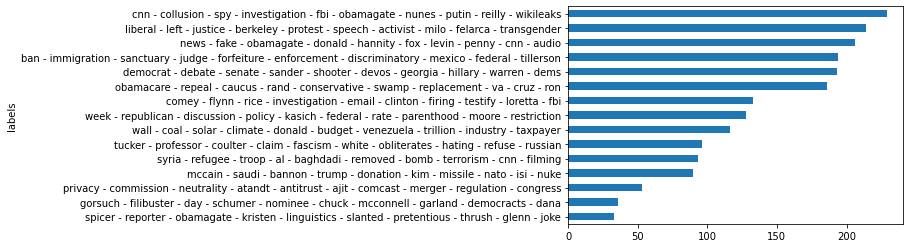

In [ ]:
results_post_ec["politics"].labels.value_counts().sort_values().plot(kind = 'barh')


<AxesSubplot:ylabel='labels'>

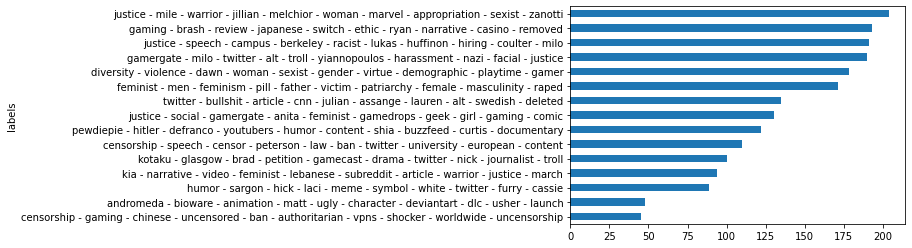

In [ ]:
results_post_ec["minority"].labels.value_counts().sort_values().plot(kind = 'barh')


<AxesSubplot:ylabel='labels'>

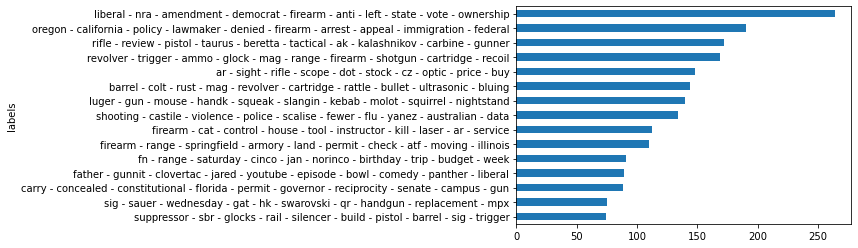

In [ ]:
results_post_ec["guncontrol"].labels.value_counts().sort_values().plot(kind = 'barh')


In [ ]:
with open(f"/content/drive/MyDrive/text_analysis/models/topic_modeling_ec_posts.pickle", 'wb') as r:
            pickle.dump(results_post_ec, r, protocol=pickle.HIGHEST_PROTOCOL)   